In [9]:
import numpy as np
import matplotlib.pyplot as plt

def wigner_function(state, x, y):
    """
    Calculate the Wigner function for a given quantum state.
    
    Parameters:
    state: np.ndarray - Density matrix of the quantum state.
    x: np.ndarray - X-axis points.
    y: np.ndarray - Y-axis points.
    
    Returns:
    np.ndarray - Wigner function values.
    """
    W = np.zeros((len(x), len(y)), dtype=np.complex128)

    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            # Calculate the Wigner function using the density matrix
            for m in range(state.shape[0]):
                for n in range(state.shape[0]):
                    W[i, j] += state[m, n] * np.exp(-2j * (xi * (m - n) + yj * (m + n)))
                    
    return W / (2 * np.pi)

def random_pure_state(d):
    """
    Generate a random pure state in d-dimensional Hilbert space.
    
    Parameters:
    d: int - Dimension of the Hilbert space.
    
    Returns:
    np.ndarray - Random pure state (density matrix).
    """
    # Generate a random vector on the complex sphere (for pure state)
    theta = np.random.rand() * np.pi
    phi = np.random.rand() * 2 * np.pi
    
    state = np.zeros((d,), dtype=np.complex128)
    state[0] = np.cos(theta)
    state[1:] = np.sin(theta) * np.exp(1j * phi * np.arange(1, d))
    
    # Normalize
    return np.outer(state, np.conjugate(state))

def generate_wigner_distributions(num_states, d, num_points):
    """
    Generate Wigner distributions for a number of random quantum states.
    
    Parameters:
    num_states: int - Number of states to generate.
    d: int - Dimension of the Hilbert space.
    num_points: int - Number of points in each direction.
    
    Returns:
    List[np.ndarray] - List of Wigner functions.
    """
    x = np.linspace(-5, 5, num_points)
    y = np.linspace(-5, 5, num_points)
    
    wigner_distributions = []
    
    for _ in range(num_states):
        state = random_pure_state(d)
        W = wigner_function(state, x, y)
        wigner_distributions.append(np.real(W))  # Only real part for visualization and loss computation
    
    return wigner_distributions


MMD Value between two sets of Wigner distributions: 0.6321


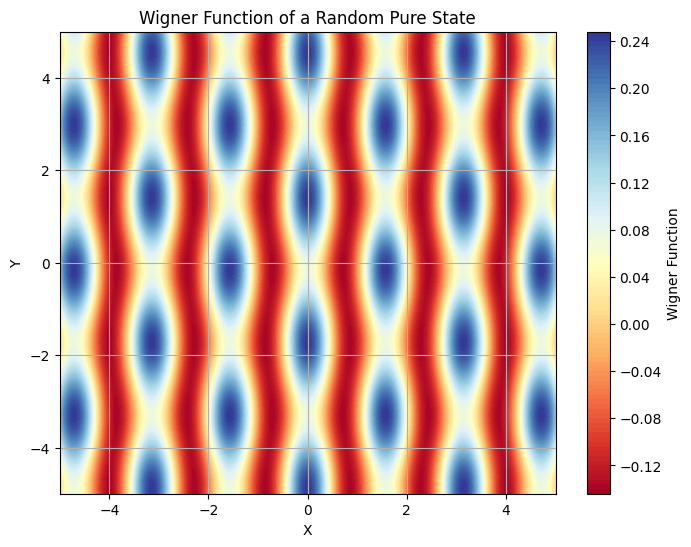

In [10]:
# Example usage
num_states = 5  # Number of random states
d = 2  # Dimension of Hilbert space (e.g., qubit)
num_points = 200  # Number of points in each direction

# Generate Wigner distributions
X = generate_wigner_distributions(num_states, d, num_points)
Y = generate_wigner_distributions(num_states, d, num_points)

from qcbm.mmd import mmd_loss

# Calculate MMD loss

XX = [x.flatten() for x in X]
YY = [y.flatten() for y in Y]

mmd_value = mmd_loss(1.0, XX, YY)
print(f"MMD Value between two sets of Wigner distributions: {mmd_value:.4f}")

# Optional: Visualizing one of the Wigner functions
plt.figure(figsize=(8, 6))
plt.contourf(np.linspace(-5, 5, num_points), np.linspace(-5, 5, num_points), X[0], levels=100, cmap='RdYlBu')
plt.colorbar(label='Wigner Function')
plt.title('Wigner Function of a Random Pure State')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

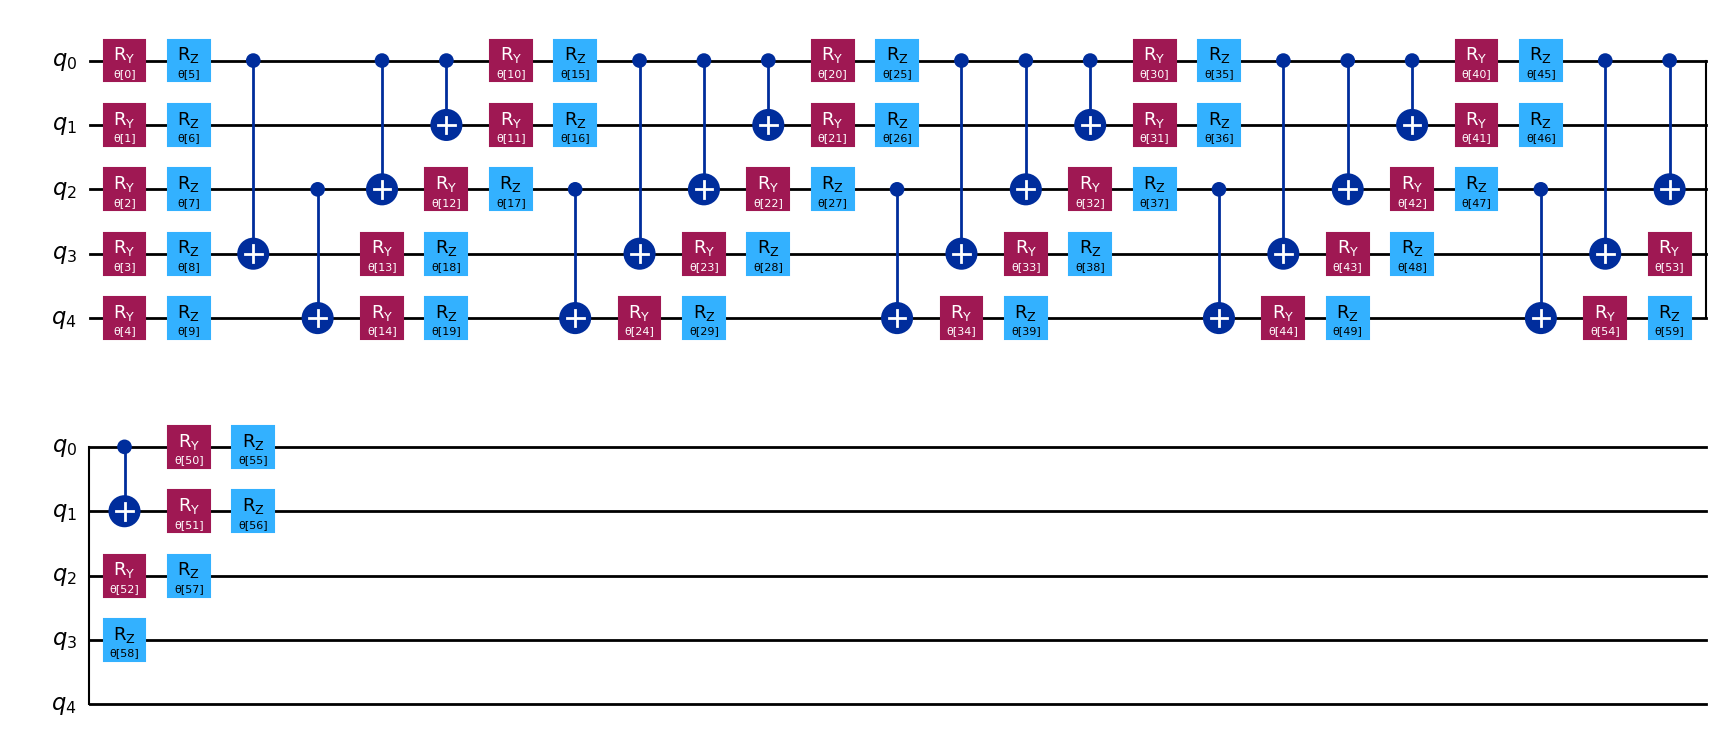

In [7]:
import qcbm.circuit as circ
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

arr = np.array([[0, 1, 0, 0, 0], [0, 1, 1, 0, 1], [1, 1, 1, 1, 1]])
n=5

pairs = circ.get_entangled_pairs(arr)
qcbm = EfficientSU2(n, entanglement=pairs, reps=5, flatten=True)
qcbm.draw(output='mpl')


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

IBM_QUANTUM_API_TOKEN = ""
QiskitRuntimeService.save_account(channel="ibm_quantum", token=IBM_QUANTUM_API_TOKEN)

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

In [20]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import AerSimulator


backend = AerSimulator()
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qcbm_isa = pm.run(qcbm)

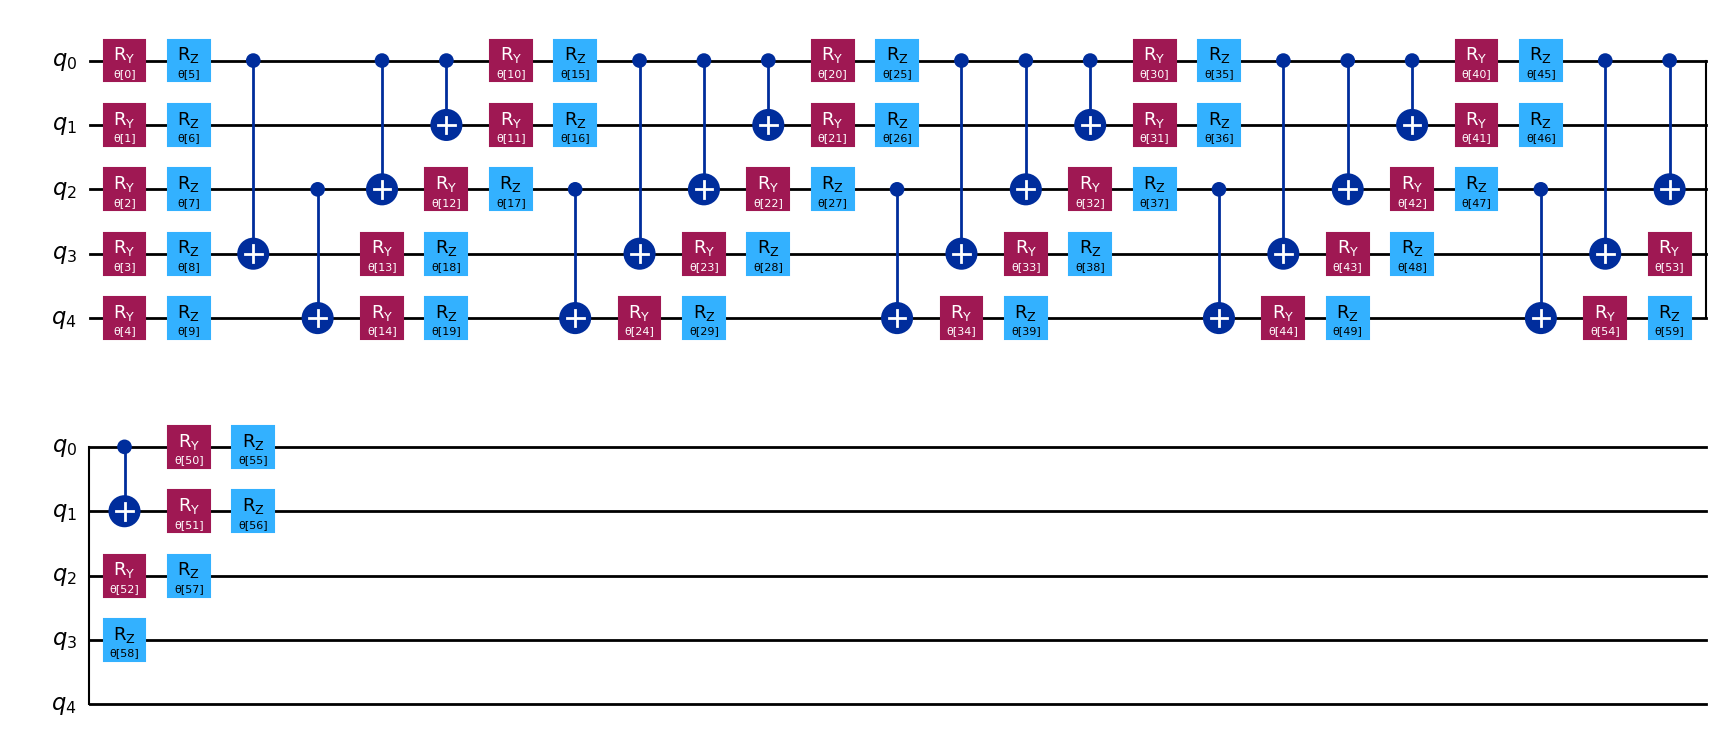

In [21]:
qcbm_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [22]:
qcbm.num_parameters

60

In [91]:
x0 = 2 * np.pi * np.random.random(qcbm.num_parameters)

binary_strings = ['000', '001', '010', '011', '100', '101', '110', '111']

target_probs = np.array([0.05, 0.10, 0.05, 0.15, 0.20, 0.05, 0.30, 0.10])

target_probs /= np.sum(target_probs)

target_distribution = dict(zip(binary_strings, target_probs))

center_state = '100'
center_idx = binary_strings.index(center_state)

sigma = 1.0  
target_probs = np.exp(-0.5 * ((np.arange(len(binary_strings)) - center_idx) / sigma) ** 2)

target_probs /= np.sum(target_probs)

target_distribution = dict(zip(binary_strings, target_probs))

In [92]:
cost_history_dict = {}

In [93]:
from qiskit_ibm_runtime import Sampler

def cost_func(params, ansatz, target_probs, sampler):
    param_dict = dict(zip(ansatz.parameters, params))

    bound_ansatz = ansatz.assign_parameters(param_dict)

    result = sampler.run([bound_ansatz]).result()[0]

    counts = result.data.alpha.array

    generated_probs = np.array([counts.get(bin_str, 0) for bin_str in binary_strings])
    generated_probs /= np.sum(generated_probs)

    loss = mmd_loss(generated_probs, target_probs)

    print(f"Params: {params}, Loss: {loss}")

    return loss


In [94]:
from scipy.optimize import minimize
from qiskit_ibm_runtime import EstimatorV2, Session
from qiskit_ibm_runtime import Sampler
from qiskit.primitives import StatevectorSampler


from qcbm.mmd import mmd_loss

with Session(backend=backend) as session:
    sampler = StatevectorSampler(default_shots=10000)
    
    # Initial parameters for the optimization
    x0 = np.random.rand(qcbm.num_parameters)

    # Optimize the parameters using COBYLA method
    res = minimize(
        cost_func,
        x0,  # initial guess for the parameters
        args=(qcbm_isa, target_probs, sampler),  # additional arguments for cost_func
        method="COBYLA",  # Optimization method
    )

AttributeError: 'DataBin' object has no attribute 'alpha'

In [ ]:
qcbm_isa.assign_parameters(res.x)